# Exploratory Data Analysis

We will first analyze the structure of the data, including which features to include, correlation between various features and target, dropping records with null values, encoding string columns and engineering new features.

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
data = pd.read_csv("../Data/medical_no_show.csv")

In [52]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Feature Engineering

Conversion of ScheduledDay and AppointmentDay to the datetime format. Creating a new feature leadTimedays accounting for the  number of days paintient got between scheduling and appointment. Converting 
Weekday into number.

In [53]:
data["ScheduledDay"]   = pd.to_datetime(data["ScheduledDay"])
data["AppointmentDay"] = pd.to_datetime(data["AppointmentDay"])
data["LeadTimeDays"]   = (data["AppointmentDay"] - data["ScheduledDay"]).dt.days.clip(lower=0)
data["Weekday"]        = data["AppointmentDay"].dt.weekday   # 0=Mon … 6=Sun

In [54]:
data.isna().sum() ## No null values at all

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
LeadTimeDays      0
Weekday           0
dtype: int64

IDs are not expected to have any sort of relationship with NoShow so they are dropped.

In [55]:
#Drop useless ID columns
data = data.drop(columns=["PatientId", "AppointmentID","Neighbourhood"])

Convertinf the Noshow feautre from yes/no to 1/0

In [56]:
data["No-show"] = (data["No-show"] == "Yes").astype(int) #convert to int

In [57]:
# map “F” → 1, “M” → 0
data["Gender_bin"] = (data["Gender"] == "F").astype(int)
data = data.drop(columns=["Gender"])

In [58]:
#Split out X/y
feature_cols = [c for c in data.columns if c != "No-show"]
X = data[feature_cols]
y = data["No-show"]

In [59]:
data.duplicated().sum() #no duplicate rows

np.int64(722)

In [60]:
data["No-show"].value_counts(normalize=True) #somewhat imbalanced data

No-show
0    0.798067
1    0.201933
Name: proportion, dtype: float64

The data is somewhat imbalanced with less records of patients actually not appearing. But we will not use any imbalance techniques.

In [61]:
# Train/val split 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [62]:
# Scale continuous features
cont_cols = ["Age", "LeadTimeDays"]
scaler = StandardScaler().fit(X_train[cont_cols])
X_train[cont_cols] = scaler.transform(X_train[cont_cols])
X_val[cont_cols]   = scaler.transform(X_val[cont_cols])

In [63]:
data.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,LeadTimeDays,Weekday,Gender_bin
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.532739,1.858243,0.649977
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.027729,1.371672,0.476979
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,1.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,3.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,5.000000,1.000000


#### The final correlation heatmap

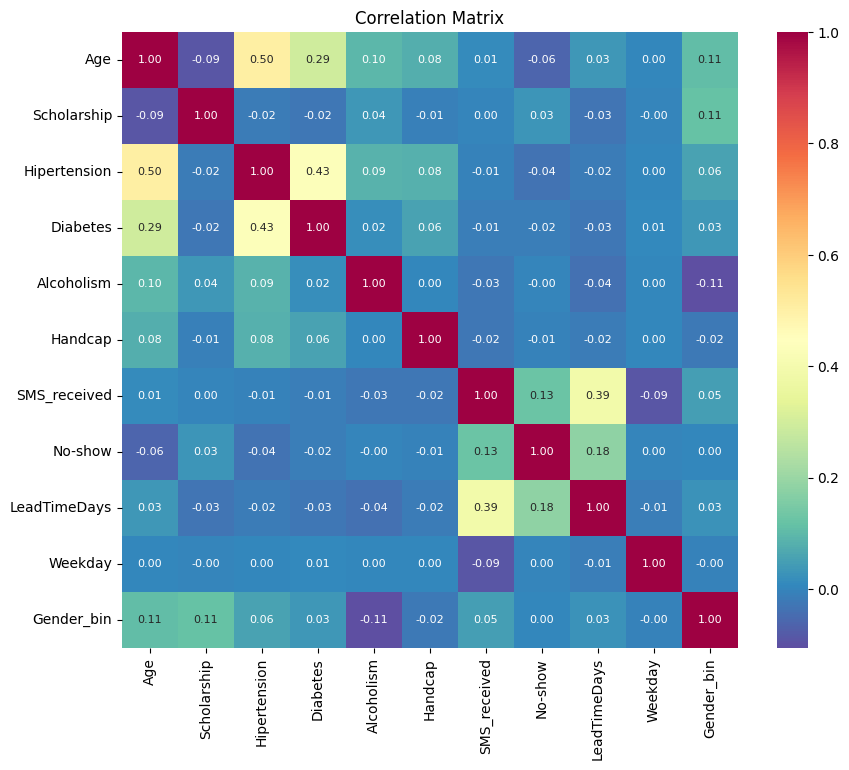

In [64]:
corrmat = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corrmat, 
            cbar=True, 
            annot=True, 
            square=True, 
            fmt='.2f', 
            annot_kws={'size': 8}, 
            cmap="Spectral_r")
plt.title("Correlation Matrix")
plt.show()

## Conclusion

We will keep all these features, since there are only 10 of them, it's cheap. 
Even though there are only two features showing correlation with no-show, Neural networks can still learn non linear data fairly well.
Our data is now processed and ready to be feeded into a neural network.